Conda install paths for required modules:

conda install -c conda-forge google-cloud-storage numpy scipy pandas xarray arm_pyart pyproj matplotlib

conda install -c anaconda python-dateutil

In [1]:
import os
import subprocess
from glob import glob
from google.cloud import storage
import tarfile


import numpy as np
import numpy.ma as ma
from scipy import stats
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import pyart
from pyproj import Proj, Geod

import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
os.getcwd()

'/home/users/wkjones/python/jupyter_notebooks/example_notebooks'

In [3]:
# nexrad_dir = './data/nexrad'
# goes_dir = './data/goes'
nexrad_dir = '/gws/nopw/j04/eo_shared_data_vol2/scratch/radar/nexrad_l2/'
goes_dir = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/MCMIPC/'


if not os.path.isdir(nexrad_dir):
    os.makedirs(nexrad_dir)

if not os.path.isdir(goes_dir):
    os.makedirs(goes_dir)


In [13]:
# Set dates: files will be searched for and downloaded if missing in this range
start_date = datetime(2018, 6, 19, 16)
end_date = datetime(2018, 6, 19, 20)
date_list = pd.date_range(start_date, end_date, freq='H', closed='left').to_pydatetime().tolist()

In [14]:
"%04i/%02i/%02i/%02i" % (start_date.year, start_date.month, start_date.day, start_date.hour)

'2018/06/19/19'

# Get GOES-ABI and NEXRAD files from google cloud storage

Note, you need to set up account authentication first and set the "GOOGLE_APPLICATION_CREDENTIALS" environment variable. See: https://cloud.google.com/docs/authentication/getting-started

This downloads about 2.7GB of data

In [15]:
storage_client = storage.Client()

In [16]:
goes_bucket = storage_client.get_bucket('gcp-public-data-goes-16')

There's a lot of different abi products avaiable, but I think it's best for now to work with the multi-channel cloud and moisture imagery product (MCMIP), as this contains all the channels from the raw data, calibrated and converted to reflectance or temperature values. Any method that works with this dataset could also easily be made to work with the raw level 1 data available directly from the satellite

In [22]:
# Search for and get goes_files
for date in date_list:
    s_year = str(date.year).zfill(4)
    doy = (date - datetime(date.year,1,1)).days+1
    s_doy = str(doy).zfill(3)
    s_hour = str(date.hour).zfill(2)
    files = [f.split('/')[-1] for f in 
             glob(goes_dir+'/'+s_year+'/'+s_doy+'/'+s_hour+'/OR_ABI-L2-MCMIPC-M[36]_G16_s'+s_year+s_doy+s_hour+'*.nc')]
    
    blobs = goes_bucket.list_blobs(
            prefix='ABI-L2-MCMIPC/'+s_year+'/'+s_doy+'/'+s_hour+'/OR_ABI-L2-MCMIPC-', 
            delimiter='/'
            )
    
    for blob in blobs:
        if blob.name.split('/')[-1] not in files:
            print(blob.name.split('/')[-1])
            blob.download_to_filename(goes_dir+'/'+s_year+'/'+s_doy+'/'+s_hour+'/'+blob.name.split('/')[-1])

goes_files = []
for date in date_list:
    s_year = str(date.year).zfill(4)
    doy = (date - datetime(date.year,1,1)).days+1
    s_doy = str(doy).zfill(3)
    s_hour = str(date.hour).zfill(2)
    goes_files += glob(goes_dir+'/'+s_year+'/'+s_doy+'/'+s_hour+'/OR_ABI-L2-MCMIPC-M[36]_G16_s'+s_year+s_doy+s_hour+'*.nc')

print('Files discovered:', len(goes_files))

Files discovered: 12


In [24]:
nexrad_bucket = storage_client.get_bucket('gcp-public-data-nexrad-l2')

In [25]:
# Pull out specific sites over Florida. There are a lot more sites covering the entire US (all site codes starting with 'K')
nexrad_sites = ['KTBW','KMLB','KAMX','KJAX','KVAX','KCLX','KTLH','KJGX','KEOX']

In [10]:
for date in date_list:
    s_year = str(date.year).zfill(4)
    s_month = str(date.month).zfill(2)
    s_day = str(date.day).zfill(2)
    s_hour = str(date.hour).zfill(2)

    for site in nexrad_sites:
        files = [f.split('/')[-1] for f in 
                 glob(nexrad_dir+'/NWS_NEXRAD_NXL2DPBL_'+site+'_'+s_year+s_month+s_day+s_hour+'*.tar')]
        blobs = nexrad_bucket.list_blobs(
                    prefix=s_year+'/'+s_month+'/'+s_day+'/'+site+'/NWS_NEXRAD_NXL2DPBL_'+site+'_'+s_year+s_month+s_day+s_hour, 
                    delimiter='/'
                    )
        for blob in blobs:
            if blob.name.split('/')[-1] not in files:
                print(blob.name.split('/')[-1])
                blob.download_to_filename(nexrad_dir+'/'+blob.name.split('/')[-1])

nexrad_files = []
for date in date_list:
    s_year = str(date.year).zfill(4)
    s_month = str(date.month).zfill(2)
    s_day = str(date.day).zfill(2)
    s_hour = str(date.hour).zfill(2)

    for site in nexrad_sites:
        nexrad_files += glob(nexrad_dir+'/NWS_NEXRAD_NXL2DPBL_'+site+'_'+s_year+s_month+s_day+s_hour+'*.tar')

print('Files discovered:', len(nexrad_files))

Files discovered: 16


In [29]:
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(goes_files, concat_dim='t', combine='nested').isel({'x':slice(1350,1500), 'y':slice(700,850)})

Text(0.5, 1.0, 'Ch16: "C02"')

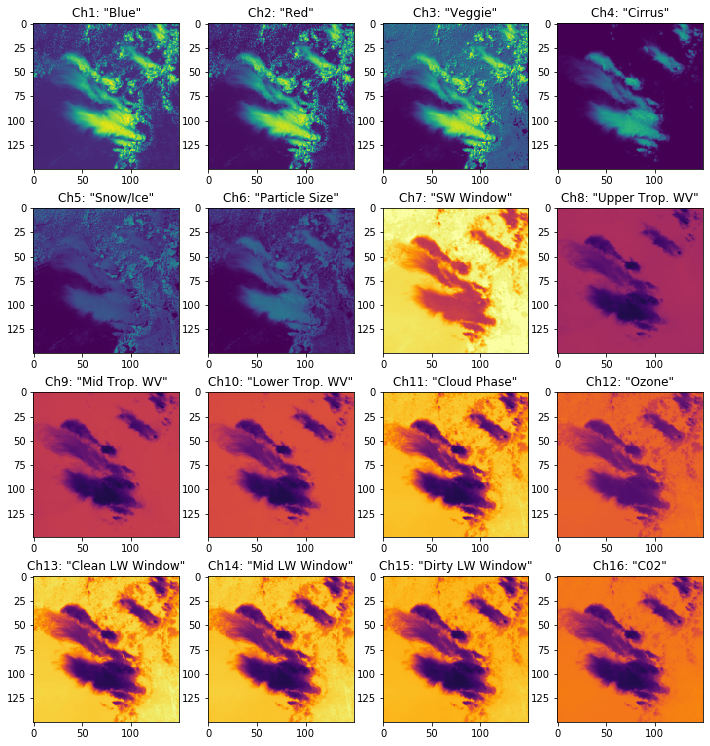

In [31]:
# Now plot all 16 channels
i = 0

fig, ax = plt.subplots(4,4, figsize=(12,13))
ax[0,0].imshow(goes_ds.CMI_C01[i], cmap='viridis', vmin=0, vmax=1)
ax[0,0].set_title('Ch1: "Blue"')

ax[0,1].imshow(goes_ds.CMI_C02[i], cmap='viridis', vmin=0, vmax=1)
ax[0,1].set_title('Ch2: "Red"')

ax[0,2].imshow(goes_ds.CMI_C03[i], cmap='viridis', vmin=0, vmax=1)
ax[0,2].set_title('Ch3: "Veggie"')

ax[0,3].imshow(goes_ds.CMI_C04[i], cmap='viridis', vmin=0, vmax=1)
ax[0,3].set_title('Ch4: "Cirrus"')

ax[1,0].imshow(goes_ds.CMI_C05[i], cmap='viridis', vmin=0, vmax=1)
ax[1,0].set_title('Ch5: "Snow/Ice"')

ax[1,1].imshow(goes_ds.CMI_C06[i], cmap='viridis', vmin=0, vmax=1)
ax[1,1].set_title('Ch6: "Particle Size"')

ax[1,2].imshow(goes_ds.CMI_C07[i], cmap='inferno', vmin=190, vmax=310)
ax[1,2].set_title('Ch7: "SW Window"')

ax[1,3].imshow(goes_ds.CMI_C08[i], cmap='inferno', vmin=190, vmax=310)
ax[1,3].set_title('Ch8: "Upper Trop. WV"')

ax[2,0].imshow(goes_ds.CMI_C09[i], cmap='inferno', vmin=190, vmax=310)
ax[2,0].set_title('Ch9: "Mid Trop. WV"')

ax[2,1].imshow(goes_ds.CMI_C10[i], cmap='inferno', vmin=190, vmax=310)
ax[2,1].set_title('Ch10: "Lower Trop. WV"')

ax[2,2].imshow(goes_ds.CMI_C11[i], cmap='inferno', vmin=190, vmax=310)
ax[2,2].set_title('Ch11: "Cloud Phase"')

ax[2,3].imshow(goes_ds.CMI_C12[i], cmap='inferno', vmin=190, vmax=310)
ax[2,3].set_title('Ch12: "Ozone"')

ax[3,0].imshow(goes_ds.CMI_C13[i], cmap='inferno', vmin=190, vmax=310)
ax[3,0].set_title('Ch13: "Clean LW Window"')

ax[3,1].imshow(goes_ds.CMI_C14[i], cmap='inferno', vmin=190, vmax=310)
ax[3,1].set_title('Ch14: "Mid LW Window"')

ax[3,2].imshow(goes_ds.CMI_C15[i], cmap='inferno', vmin=190, vmax=310)
ax[3,2].set_title('Ch15: "Dirty LW Window"')

ax[3,3].imshow(goes_ds.CMI_C16[i], cmap='inferno', vmin=190, vmax=310)
ax[3,3].set_title('Ch16: "C02"')


The ABI multi-channel cloud and moisture imagery product (MCMIP) contains all the data from the 16 channels aboard ABI, converted to either a reflectance value or a brightness temperature, and regridded to a 2km grid scale

Channels 1-6 are all reflected sunlight which is either visible (blue and red) or in the near infra-red. These are plotted in blue-yellow and range from 0 to 1. Clouds show up brightly in most of these channels. Note that these will only show anything during daytime!

Channels 8-16 are emitted infra-red radiation by the earth's surface and the atmosphere. These are plotted in Purple-yellow and are scaled between 190 and 310K (-80C to 40C). Objects that are higher in the atmosphere show up as colder, with storm clouds showing up as particularly cold. Other absorbers such as water vapour (WV), Ozone and CO2 also show up as colder backgrounds.

Channel 7 is a mixed channel, as it both contains emitted heat and reflected sunlight. It is similar to channel 13, but much hotter in the daytime due to reflected light.

For more info on all these channels see: https://www.goes-r.gov/mission/ABI-bands-quick-info.html

Channels 8, 10, 13 and 15 are likely the most useful for tracking deep convection. 2, 4 and 7 can also be useful, but only during daytime

Some combinations and/or differences in are also useful. For example, the split window difference (channel 13 - channel 15) shows both water vapour near the surface, and thin ice clouds. For more info see: https://www.goes-r.gov/users/training/imagery.html

In [17]:
# The data itself is contained in a dask datarray:
goes_ds.CMI_C13.data

dask.array<getitem, shape=(24, 150, 150), dtype=float32, chunksize=(1, 150, 150), chunktype=numpy.ndarray>

# Regridding radar data to the abi grid

Now let's look at read the radar data and regridding it to the goes grid

First we need to set up a Proj4 projection for the goes-abi view

In [78]:
height = goes_ds.goes_imager_projection.perspective_point_height
lat_0 = goes_ds.goes_imager_projection.latitude_of_projection_origin
lon_0 = goes_ds.goes_imager_projection.longitude_of_projection_origin
sweep = goes_ds.goes_imager_projection.sweep_angle_axis

goes_proj = Proj(proj='geos', h=height,
                lon_0=lon_0, lat_0=lat_0, sweep=sweep)

In [79]:
goes_proj

Proj('+proj=geos +h=35786023.0 +lon_0=-75.0 +lat_0=0.0 +sweep=x', preserve_units=True)

In [80]:
# Now set up the bin edges for the goes dataset coordinates. Note we multiply by height to convert into the Proj coords
x_bins = np.zeros(goes_ds.x.size+1)
x_bins[:-1] += goes_ds.x
x_bins[1:] += goes_ds.x
x_bins[1:-1] /= 2
x_bins *= height

y_bins = np.zeros(goes_ds.y.size+1)
y_bins[:-1] += goes_ds.y
y_bins[1:] += goes_ds.y
y_bins[1:-1] /= 2
y_bins *= height


File reading is quite slow as it has to unpack and load many files in a row (and the pyart loading function is quite slow). You may want to just look at the first file for an example

In [ ]:
# Now lets loop over the files and get all the data within our domain
x_list, y_list, ref_list, t_list = [],[],[],[]

for tf in nexrad_files:
    print(tf.split('/')[-1])
    # The nexrad files are all contained in tars, so we need to unpack them
    with tarfile.open(tf) as tar:
        # Loop iver each element and inspect to see if they are actual radar archive files (there is also metadata in the tar)
        for item in [name for name in tar.getnames() if name[-9:] == '_V06.ar2v']:
            try:
                radar = pyart.io.read_nexrad_archive(tar.extractfile(tar.getmember(item)), 
                                                     include_fields=['reflectivity'],
                                                     delay_field_loading=True)
            except IOError:
                pass
            else:
                start_time = parse_date(item[4:19], fuzzy=True)

                rad_time = [start_time+timedelta(seconds=t) for t in radar.time['data']]
                rad_alt = radar.gate_altitude['data']
                rad_lat = radar.gate_latitude['data']
                rad_lon = radar.gate_longitude['data']
                rad_data = radar.fields['reflectivity']['data']
#               Get the radar field locations in abi coordinates
                rad_x, rad_y = goes_proj(rad_lon, rad_lat)
#               New parallax "uncorrection"
#               The goes data has a parallax offset due to the angle of the image viewing. 
#               We need to add this in to the nexrad data to make it line up properly
                dlat = np.degrees(rad_alt*np.tan(np.radians(rad_lat-lat_0) + rad_y/height)/6.371E6)
                dlon = np.degrees(rad_alt*np.tan(np.radians(rad_lon-lon_0) + rad_x/height)/6.371E6)
                rad_x, rad_y = goes_proj(rad_lon+dlon, rad_lat+dlat)
                
#               Now we mask any of the data that is outside the domain, too close to the ground or too high
                mask = np.any([rad_data.mask,
                               rad_x>(goes_ds.x.max().data*height),
                               rad_x<(goes_ds.x.min().data*height),
                               rad_y>(goes_ds.y.max().data*height),
                               rad_y<(goes_ds.y.min().data*height),
                               rad_alt<2000, rad_alt>15000], 0)

                t = ma.array(np.tile(rad_time, (1,rad_lat.shape[1])), mask=mask)
                y = ma.array(rad_y, mask=mask)
                x = ma.array(rad_x, mask=mask)
                ref = ma.array(rad_data, mask=mask)
                if not np.all(mask):
                    x_list.append(x.compressed())
                    y_list.append(y.compressed())
                    t_list.append(t.compressed())
                    ref_list.append(ref.compressed())

if len(x_list)>0:
    x = ma.concatenate(x_list, 0)
    y = ma.concatenate(y_list, 0)
    t = ma.concatenate(t_list, 0)
    t.fill_value = datetime(2000, 1, 1)
    ref = ma.concatenate(ref_list, 0)

else:
    raise ValueError("No valid radar data found")

In [31]:
def get_abi_date_from_filename(filename):
    base_string = filename.split('/')[-1].split('_s')[-1]
    date = parse_date(base_string[:4]+'0101'+base_string[7:13]) + timedelta(days=int(base_string[4:7])-1)
    return date

goes_dates = [get_abi_date_from_filename(f) for f in goes_files]
print(goes_dates[12])

2018-06-19 18:02:24


Now lets regrid the radar data for one time period

In [67]:
wh_t = np.logical_and(t>goes_dates[12], t<(goes_dates[12]+timedelta(minutes=5)))
# Note we need to reverse the y coordinates because they are decreasing, not increasing
regrid_radar = ma.array(stats.binned_statistic_dd((y[wh_t], x[wh_t]),
                                                   ref[wh_t],
                                                   statistic='mean',
                                                   bins=(y_bins[::-1], x_bins),
                                                   expand_binnumbers=True)[0][::-1])

# Note, it would be nice to use max rather than mean (or the top 5% of values within each bin), 
#   but this is currently much slower to compute

Plotting next to the abi data

Text(0.5, 1.0, 'Regridded radar reflectivity')

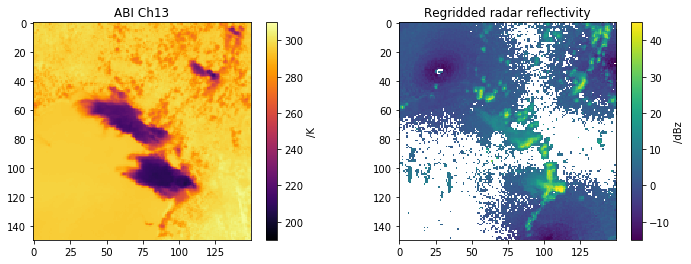

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

abi_img = ax[0].imshow(goes_ds.CMI_C13[12], cmap='inferno', vmin=190, vmax=310)
plt.colorbar(abi_img, label='/K', ax=ax[0])
ax[0].set_title('ABI Ch13')

radar_img = ax[1].imshow(regrid_radar, cmap='viridis', vmin=-15, vmax=45)
plt.colorbar(radar_img, label='/dBz', ax=ax[1])
ax[1].set_title('Regridded radar reflectivity')

Radar reflectivity of above 30-40 dBz is considered indicative of a storm cloud.

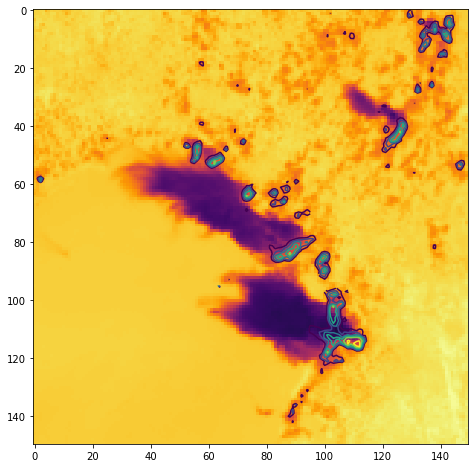

In [69]:
# Plot radar as contours over the top
fig = plt.figure(figsize=(8,8))
plt.imshow(goes_ds.CMI_C13[12], cmap='inferno', vmin=190, vmax=310)
plt.contour(regrid_radar, np.arange(20,50,5))

In [36]:
# Load pregridded radar data from file
radar_regrid_file = '/gws/nopw/j04/eo_shared_data_vol2/scratch/radar/nexrad_regrid/nexrad_goes_regrid_20180619190000.nc'
radar_ds = xr.open_dataset(radar_regrid_file).isel({'x':slice(1350,1500), 'y':slice(700,850)})

In [38]:
radar_ds

<xarray.Dataset>
Dimensions:            (t: 12, x: 150, y: 150)
Coordinates:
  * t                  (t) datetime64[ns] 2018-06-19T19:02:24 ... 2018-06-19T19:57:24
  * y                  (y) float32 0.089012004 0.088956006 ... 0.080724 0.080668
  * x                  (x) float32 -0.025732003 -0.025675997 ... -0.017388001
Data variables:
    reflectivity_mean  (t, y, x) float64 ...
    counts             (t, y, x) float64 ...

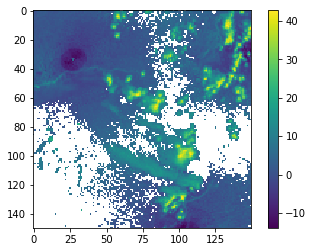

In [40]:
plt.imshow(radar_ds.reflectivity_mean[0])

plt.colorbar()

In [41]:
GLM_dir = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/19/'
GLM_files = glob(GLM_dir+"OR_GLM-L2-LCFA_G16_*.nc")
len(GLM_files)

180

In [70]:
goes_dates = goes_ds.t.to_dataframe().t.dt.to_pydatetime()

In [126]:
pd.DataFrame(data=goes_ds.t.data, columns=['t']).t.dt.to_pydatetime()

array([datetime.datetime(2018, 6, 19, 19, 3, 43, 334675),
       datetime.datetime(2018, 6, 19, 19, 8, 43, 334846),
       datetime.datetime(2018, 6, 19, 19, 13, 43, 332548),
       datetime.datetime(2018, 6, 19, 19, 18, 43, 342110),
       datetime.datetime(2018, 6, 19, 19, 23, 43, 340822),
       datetime.datetime(2018, 6, 19, 19, 28, 43, 341350),
       datetime.datetime(2018, 6, 19, 19, 33, 43, 349555),
       datetime.datetime(2018, 6, 19, 19, 38, 43, 347460),
       datetime.datetime(2018, 6, 19, 19, 43, 43, 347175),
       datetime.datetime(2018, 6, 19, 19, 48, 43, 355192),
       datetime.datetime(2018, 6, 19, 19, 53, 43, 355901),
       datetime.datetime(2018, 6, 19, 19, 58, 43, 354931)], dtype=object)

In [128]:
pd.Series(goes_ds.t.data).dt.to_pydatetime()

array([datetime.datetime(2018, 6, 19, 19, 3, 43, 334675),
       datetime.datetime(2018, 6, 19, 19, 8, 43, 334846),
       datetime.datetime(2018, 6, 19, 19, 13, 43, 332548),
       datetime.datetime(2018, 6, 19, 19, 18, 43, 342110),
       datetime.datetime(2018, 6, 19, 19, 23, 43, 340822),
       datetime.datetime(2018, 6, 19, 19, 28, 43, 341350),
       datetime.datetime(2018, 6, 19, 19, 33, 43, 349555),
       datetime.datetime(2018, 6, 19, 19, 38, 43, 347460),
       datetime.datetime(2018, 6, 19, 19, 43, 43, 347175),
       datetime.datetime(2018, 6, 19, 19, 48, 43, 355192),
       datetime.datetime(2018, 6, 19, 19, 53, 43, 355901),
       datetime.datetime(2018, 6, 19, 19, 58, 43, 354931)], dtype=object)

In [131]:
goes_ds.t.data[0].tolist()

1529435023334675968

In [139]:
bob = goes_ds.t.data[0]
print(type(bob))
print(bob.tolist())

<class 'numpy.datetime64'>
1529435023334675968


In [143]:
bob=np.datetime64('2005-02-01 22:01:45')

In [144]:
datetime.utcfromtimestamp(bob.tolist()/1e9)

TypeError: unsupported operand type(s) for /: 'datetime.datetime' and 'float'

In [72]:
goes_dates[0]

datetime.datetime(2018, 6, 19, 19, 3, 43, 334675)

In [74]:
from python_toolbox import abi_tools

In [96]:
p = abi_tools.get_abi_proj(goes_ds)
height=goes_ds.goes_imager_projection.perspective_point_height
glm_dates_array = np.array([abi_tools.get_abi_date_from_filename(f) for f in GLM_files])
# Get lightning event and flash locations
event_x = []
event_y = []
flash_x = []
flash_y = []
for date in goes_dates:
#     abi_file = goes_files[f_ind]
    wh_dates = np.all([glm_dates_array>=date, glm_dates_array<(date+timedelta(minutes=5))], axis=0)
    matched_glm_files = np.array(GLM_files)[wh_dates]
    t_event_x = []
    t_event_y = []
    t_flash_x = []
    t_flash_y = []
    for glm_file in matched_glm_files:
        with xr.open_dataset(glm_file) as glm_ds:
            temp_x, temp_y = (output/height for output in p(glm_ds.event_lon.data, glm_ds.event_lat.data))
            t_event_x.append(temp_x)
            t_event_y.append(temp_y)
            temp_x, temp_y = (output/height for output in p(glm_ds.flash_lon.data, glm_ds.flash_lat.data))
            t_flash_x.append(temp_x)
            t_flash_y.append(temp_y)

    event_x.append(np.concatenate(t_event_x))
    event_y.append(np.concatenate(t_event_y))
    flash_x.append(np.concatenate(t_flash_x))
    flash_y.append(np.concatenate(t_flash_y))

In [113]:
flash_hist = np.stack([np.histogram2d(flash_y[i], flash_x[i], bins=(y_bins[::-1]/height, x_bins/height))[0]
                       for i in range(len(flash_x))])

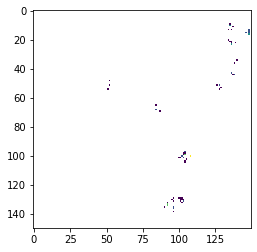

In [114]:
plt.imshow(ma.array(flash_hist[0][::-1], mask=flash_hist[0][::-1]==0),vmax=5)

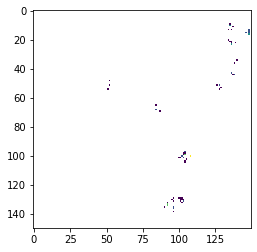

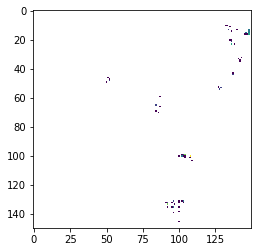

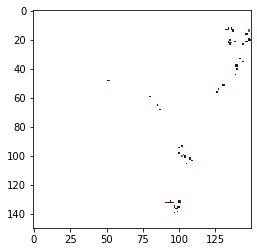

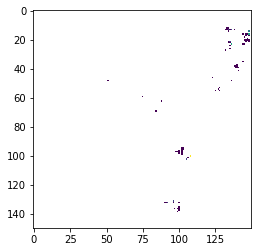

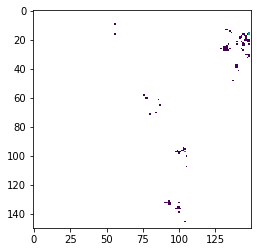

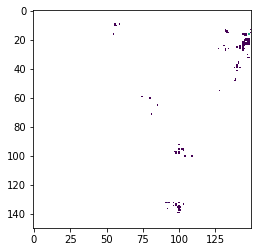

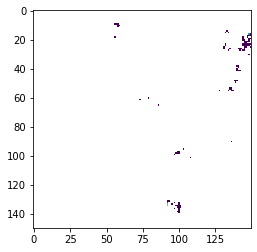

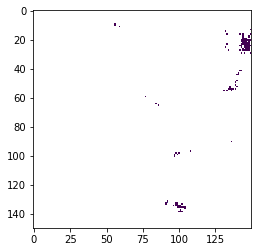

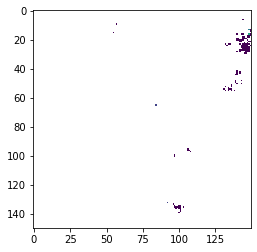

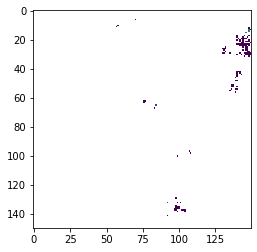

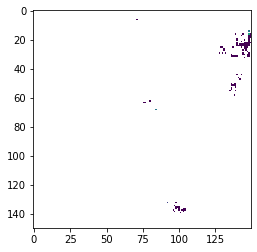

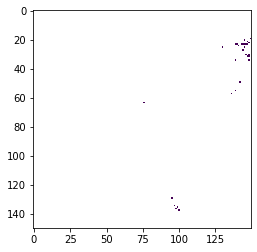

In [115]:
for i in range(12):
    plt.figure()
    plt.imshow(ma.array(flash_hist[0][::-1], mask=flash_hist[i][::-1]==0),vmax=5)

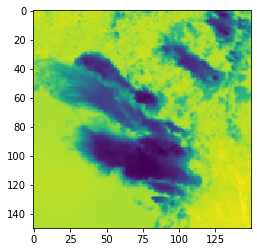

In [95]:
plt.imshow(goes_ds.CMI_C13[0])

In [104]:
flash_hist[0,0].shape

(150, 150)

In [111]:
hist_list = [np.histogram2d(flash_y[i], flash_x[i], bins=(y_bins[::-1]/height, x_bins/height))[0]
                       for i in range(len(flash_x))]

In [112]:
len(hist_list)

12

In [110]:
np.histogram2d(flash_y[0], flash_x[0], bins=(y_bins[::-1]/height, x_bins/height))[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])